In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_path = 'synthetic_data.csv'
raw_data = pd.read_csv(data_path, header=None)
# raw_data.head()

In [3]:
d_min, d_max = np.asarray(raw_data.min(1)), np.asarray(raw_data.max(1))
norm_data = np.asarray(raw_data)
den = (d_max - d_min).reshape(-1, 1)
norm_data = (norm_data - d_min.reshape(-1, 1))/den
# norm_data = pd.DataFrame(norm_data)
# norm_data.head()
# type(norm_data)

In [4]:
# Parameter initialization

gap_time = 10  # gap time between each segment
win_size = [10, 30, 60]  # window size of each segment
step_max = 5 # maximum step of ConvLSTM

train_start_id = 10
train_end_id = 800

test_start_id = 800
test_end_id = 2000

valid_start_id = 800
valid_end_id = 1000

training_iters = 5
save_model_step = 1

learning_rate = 0.0002

threhold = 0.005
alpha = 1.5

In [5]:
series_num = norm_data.shape[0]
series_len = norm_data.shape[1]
signature_matrices_num = series_len // gap_time

print("series_number is", series_num)
print("series_length is", series_len)
print("signature_matrices_number is", signature_matrices_num)

series_number is 30
series_length is 20000
signature_matrices_number is 2000


In [6]:
def signature_matrices_generation(win, data, signature_matrices_num, series_num, series_len, gap_time, series_start=0):
    if win == 0:
        print("The size of win cannot be 0")

    data = np.asarray(data)
    signature_matrices = np.zeros((signature_matrices_num, series_num, series_num))

    for t in range(series_start, series_len-win, gap_time):
        if t >= 0 * gap_time:
            data_t = data[:, t:t+win]
            signature_matrices[t//gap_time] = np.dot(data_t, data_t.T) / win

    return signature_matrices

In [7]:
signature_matrices = []
for win in win_size:
    signature_matrices.append(signature_matrices_generation(win, norm_data, signature_matrices_num, series_num, series_len, gap_time))

signature_matrices = np.asarray(signature_matrices)
print("the shape of signature_matrices is", signature_matrices.shape)

the shape of signature_matrices is (3, 2000, 30, 30)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IN_CHANNELS = 3
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 10

In [9]:
sig_mat_reshaped = np.reshape(signature_matrices, (-1, 3, 30, 30))
train_size = int(len(sig_mat_reshaped)*0.8)
test_size = len(sig_mat_reshaped) - train_size
train, test = sig_mat_reshaped[:train_size, ...], sig_mat_reshaped[train_size:, ...]
print(f'train = {train.shape} test = {test.shape}')

train = (1600, 3, 30, 30) test = (400, 3, 30, 30)


In [10]:
train_x = torch.tensor(train)
train_y = train_x
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_x = torch.tensor(test)
test_y = test_x
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# x2, y2 = next(iter(train_loader))
# x2.shape

In [11]:
class AutoencoderCNN(nn.Module):
    def __init__(self, in_channels=3):
        super(AutoencoderCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [12]:
# Initialize network
model = AutoencoderCNN(in_channels=IN_CHANNELS).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# inputsize = (3, 30, 30)
# print(summary(model, inputsize))

In [13]:
# training loop
def train(model, optimizer, criterion, epochs, train_loader, val_loader):
    for epoch in range(epochs):
        losses = []

        for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            data = data.to(device=device).float()
            targets = targets.to(device=device).float()

            # forward
            scores = model(data)
            loss = criterion(scores, targets)

            losses.append(loss.item())

            # backward
            optimizer.zero_grad()
            loss.backward()

            # gradient descent
            optimizer.step()
        
        print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

    return losses

In [14]:
losses = train(model, optimizer, criterion, N_EPOCHS, train_loader, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.55it/s]


Cost at epoch 0 is 0.03400294456630945


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.64it/s]


Cost at epoch 1 is 0.014349260553717613


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.12it/s]


Cost at epoch 2 is 0.010729665607213975


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.73it/s]


Cost at epoch 3 is 0.008156295893713831


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.83it/s]


Cost at epoch 4 is 0.005868473146110773


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.75it/s]


Cost at epoch 5 is 0.003993253749795258


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.84it/s]


Cost at epoch 6 is 0.002955540637485683


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 49.79it/s]


Cost at epoch 7 is 0.002439528680406511


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.96it/s]


Cost at epoch 8 is 0.0020887236669659614


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.03it/s]

Cost at epoch 9 is 0.001813859899993986


In [21]:
testcase = sig_mat_reshaped[400, ...].reshape((1, 3, 30, 30))
# print(testcase.shape)

testcase = torch.tensor(testcase).to(device=device).float()
reconstructcase = model(testcase)
# print(reconstructcase.shape)

testcase = testcase.reshape((30, 30, 3)).cpu().detach().numpy()
reconstructcase = reconstructcase.reshape((30, 30, 3)).cpu().detach().numpy()

diff = np.absolute(reconstructcase[..., 0] - testcase[..., 0])

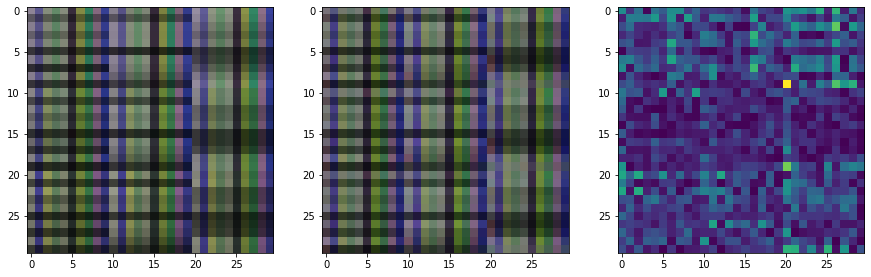

In [22]:
f, axes = plt.subplots(1,3, figsize=(15,10))
axes[0].imshow(testcase)
axes[1].imshow(reconstructcase)
axes[2].imshow(diff)